In [1]:
# 🔧 Add root to sys.path for module imports (Jupyter-safe)
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent  # Go up from /notebooks/ → experiment → project root
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"[INFO] Added ROOT to sys.path: {ROOT}")
 

[INFO] Added ROOT to sys.path: /home/arsalan


In [2]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.resume import load_pretrained_model
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [ ]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_" \
# "bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs32_ep50_lr1e-04_ds1000-g1.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")

# from experiments.exp_mamaba_vit_stack.models.hybrid_mamba_vit import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs64_ep1_lr1e-04_ds1008_g500_sched-RLRP.yml")

from models.model_vit import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_preload_trained_model_and_train_more/config/" \
# "vit_tiny_patch16_224_gaussian_bs32_ep200_lr1e-04_p60_ds1008_g500_sched-RLRP_preload_p12.yml")

# from models.model_mamba import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_alpha_s_evaluation_with_vit/config/" \
# "vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds7200000_g500_sched-RLRP_preload_p4.yml")


# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/config/" \
# "vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml")
cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/config/vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_p12_ds1008_g500_sched-RLRP_preload_p4.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4",
  "backbone": "vit_gaussian",
  "batch_size": 32,
  "epochs": 50,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
  "train_csv": "/home/arsala

In [4]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded


In [5]:
device= get_device_summary()

=== NVIDIA-SMI ===
Wed Sep 17 16:35:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P5              28W / 220W |    937MiB /  8192MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [6]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 26
[INFO] Length of validation dataloader: 4
[INFO] Length of test dataloader: 4


In [7]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using ViT model: vit_tiny_patch16_224, pretrained: False


ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none

In [8]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [9]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [10]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [11]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [12]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/training_summary.json


In [13]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [14]:
model, preloaded = load_pretrained_model(model, device, cfg)


[INFO] 🔄 Preloading model weights from experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds7200000_g500_sched_ReduceLROnPlateau_preloaded/best_model.pth
[INFO] ✅ Pretrained weights loaded successfully.


In [16]:
alpha_names = ("0.2","0.3","0.4")
q0_names    = ("1.0","1.5","2.0","2.5")


Saved images:
  α_s histogram:         experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/prob_plots/alpha_pred_hist
  α_s avg-prob bars:     experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/prob_plots/alpha_avgprob.png
  α_s probabilities:      experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/prob_plots/alpha_pred_hist_probs.csv
  α_s heatmap:           experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/prob_plots/alpha_avg

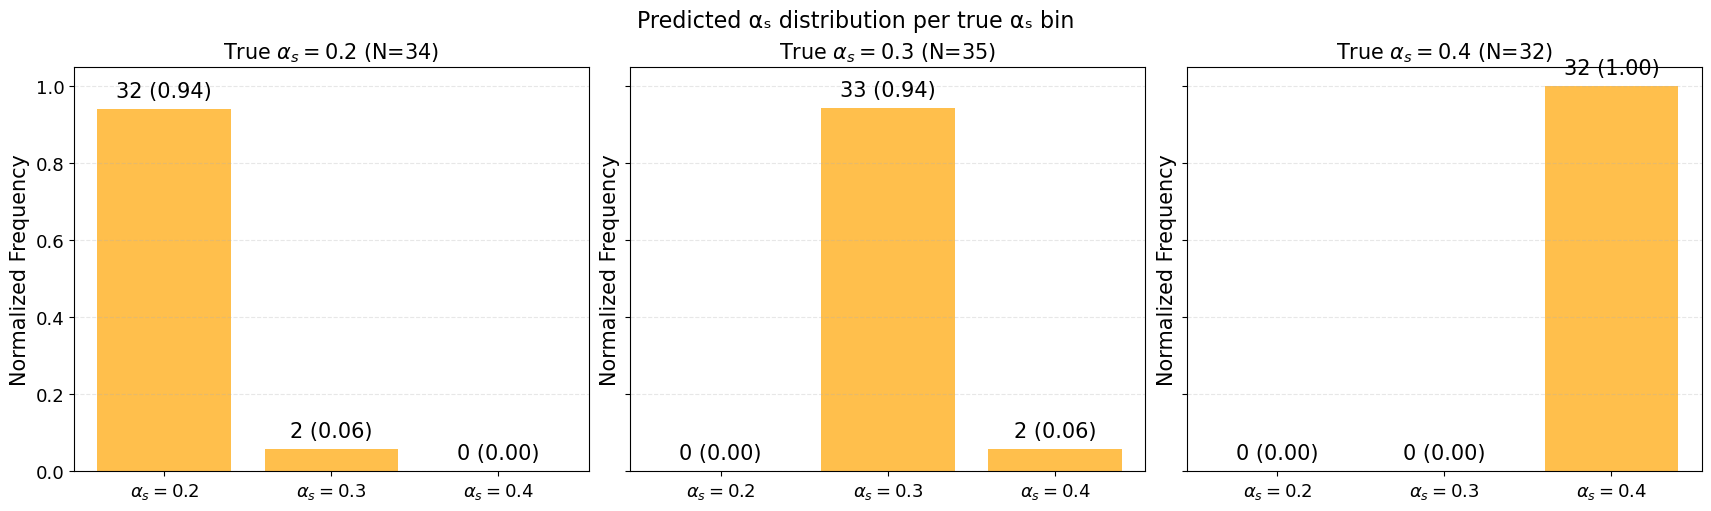

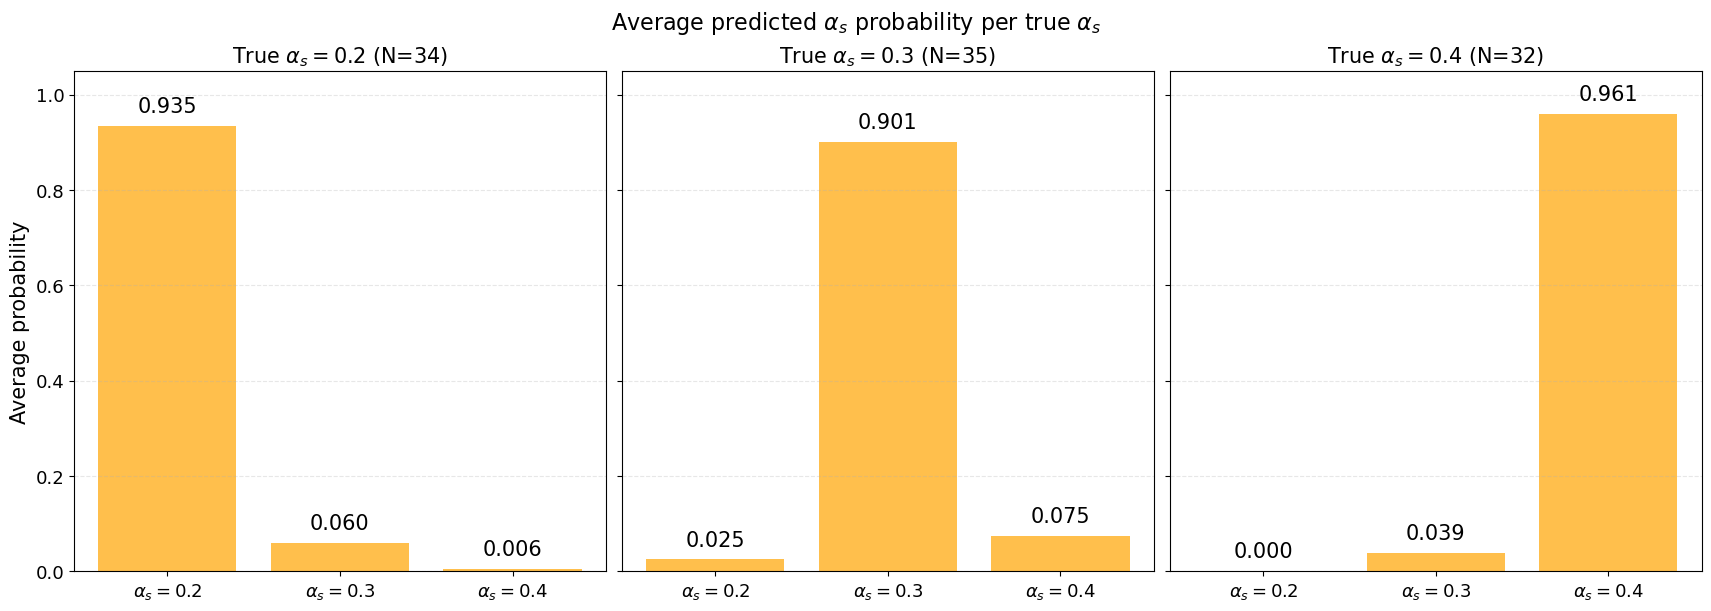

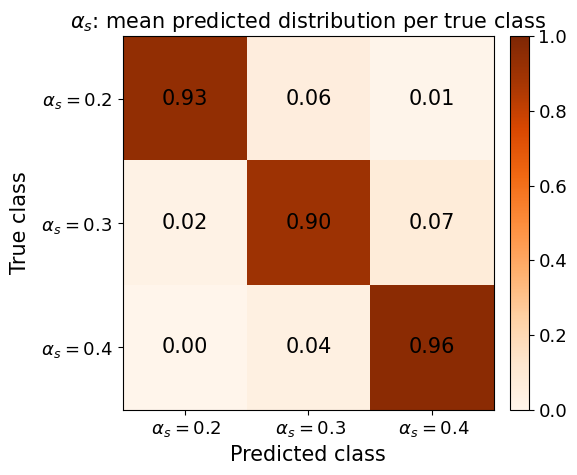

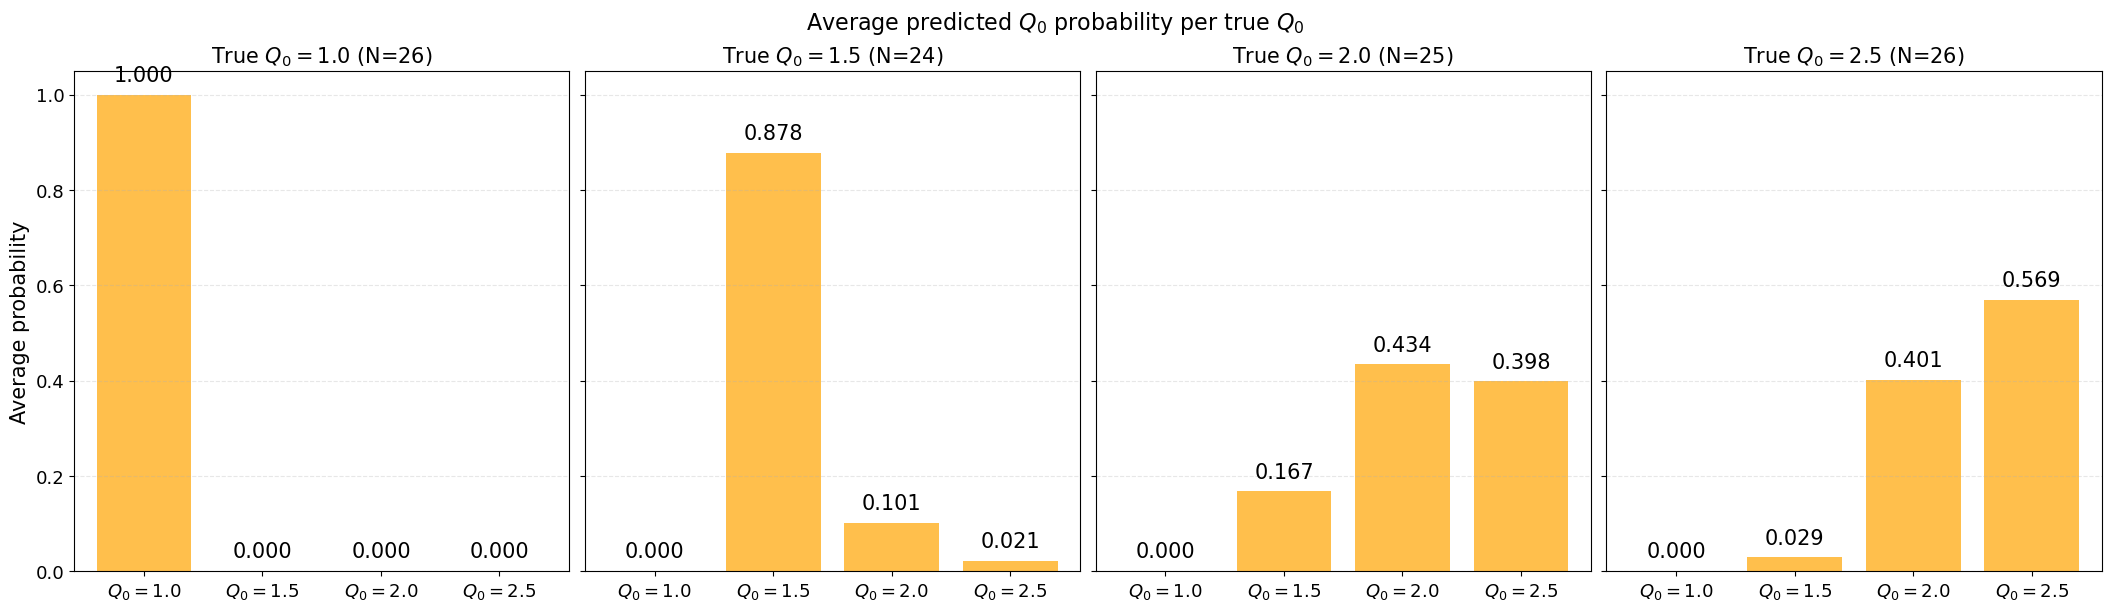

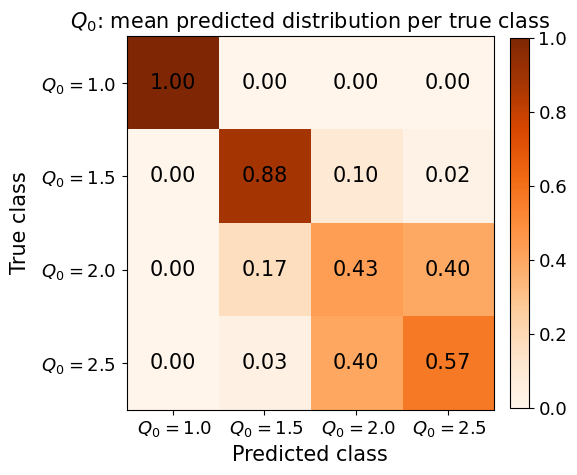

In [18]:
from train_utils.evaluate import evaluate
# experiment folder for artifacts
art_dir = os.path.join(cfg.output_dir,"val/prob_plots")
os.makedirs(art_dir, exist_ok=True)

alpha_hist_path      = os.path.join(art_dir, "alpha_pred_hist")      # .png/.pdf added by evaluate
alpha_avgprob_path   = os.path.join(art_dir, "alpha_avgprob")        # .png/.pdf added by evaluate
q0_avgprob_path      = os.path.join(art_dir, "q0_avgprob")           # .png/.pdf added by evaluate

metrics = evaluate(
    val_loader, model, criterion, device,
    loss_weights=getattr(cfg, "loss_weights", None),
    # plots:
    make_alpha_fig=True,
    alpha_fig_path=str(alpha_hist_path),
    make_alpha_avgprob_fig=True,
    alpha_avgprob_fig_path=str(alpha_avgprob_path),
    make_q0_avgprob_fig=True,
    q0_avgprob_fig_path=str(q0_avgprob_path),
    alpha_class_names=alpha_names,
    q0_class_names=q0_names,
)

print("Saved images:")
print("  α_s histogram:        ", metrics.get("alpha_hist_path"))
print("  α_s avg-prob bars:    ", metrics.get("alpha_avgprob_hist_path"))
print("  α_s probabilities:     ", metrics.get("alpha_probs_csv"))
print("  α_s heatmap:          ", metrics.get("alpha_heatmap_path"))
print("  Q0  avg-prob bars:    ", metrics.get("q0_avgprob_hist_path"))
print("  Q0  probabilities:     ", metrics.get("q0_probs_csv"))
print("  Q0  heatmap:          ", metrics.get("q0_heatmap_path"))

In [ ]:
# from train_utils.evaluate import evaluate
# metrics = evaluate(
#     val_loader, model, criterion, device,
#     make_q0_avgprob_fig=True,
#     q0_avgprob_fig_path=os.path.join(cfg.output_dir, "val/hists/q0_avgprob_per_true_bin"),
#     q0_class_names=("1.0","1.5","2.0","2.5")
# )


✅ Saved confusion matrix for energy:
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_energy.png
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_energy.pdf


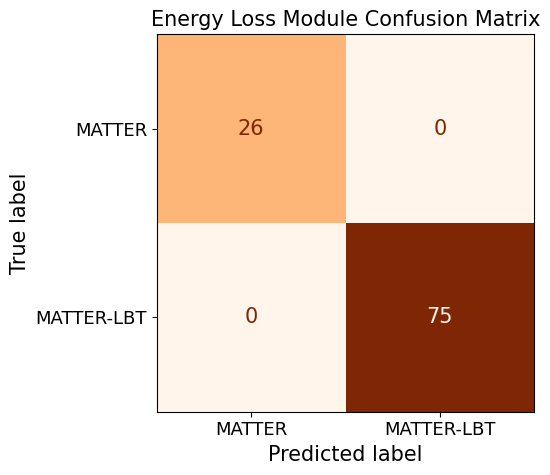

✅ Saved confusion matrix for alpha:
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_alpha.png
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_alpha.pdf


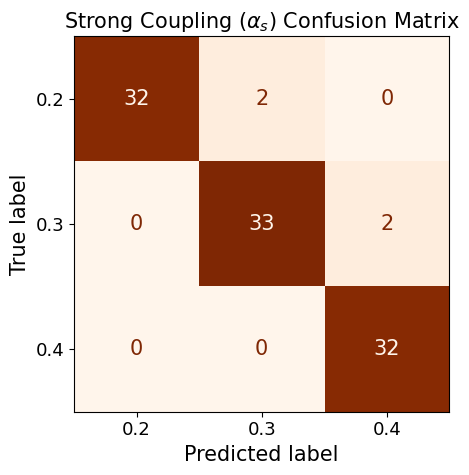

✅ Saved confusion matrix for q0:
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_q0.png
 - experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/confusion_plots/confusion_matrix_q0.pdf


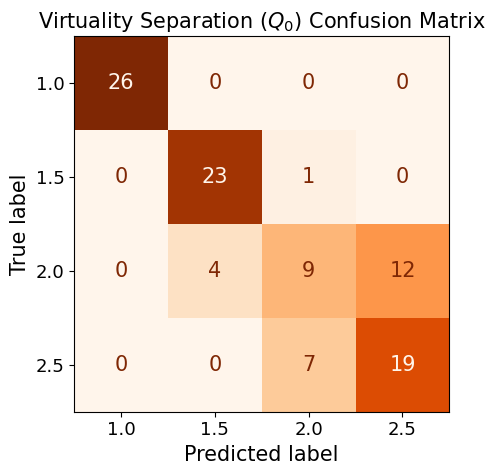

In [19]:
plot_confusion_matrices(metrics, output_dir= f"{cfg.output_dir}/val", color_map="Oranges")

In [20]:

print("Saved:", metrics.get("q0_avgprob_hist_path"))
print(f"[INFO] Energy Acc ={metrics['energy']['accuracy']:.4f}, αs Acc = {metrics['alpha']['accuracy']:.4f}, Q0 Acc = {metrics['q0']['accuracy']:.4f}, Total Acc = {metrics['accuracy']:.4f}")
print(f"[INFO] Energy Loss ={metrics['loss_energy']:.4f}, αs Loss = {metrics['loss_alpha']:.4f}, Q0 Loss = {metrics['loss_q0']:.4f}, Total Loss = {metrics['loss']:.4f}")

Saved: experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/prob_plots/q0_avgprob.png
[INFO] Energy Acc =1.0000, αs Acc = 0.9604, Q0 Acc = 0.7624, Total Acc = 0.7228
[INFO] Energy Loss =0.0000, αs Loss = 0.0952, Q0 Loss = 0.4383, Total Loss = 0.5335


In [21]:
finalize_training_summary(
    summary=training_summary,
    best_epoch="NA",
    best_acc="NA",
    best_metrics=metrics,
    output_dir=os.path.join(cfg.output_dir, "val")
)

[INFO] 📄 Training summary saved to: experiments/exp_evaluating_vit_with_q_0_probab_distirbution_plot/training_output/ViT_tiny_patch16_224_gaussian_lrp_12_rlrp_4_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/val/training_summary.json


In [ ]:
# from train_utils.evaluate import evaluate
# metrics = evaluate(
#     test_loader, model, criterion, device,
#     make_q0_avgprob_fig=True,
#     q0_avgprob_fig_path=os.path.join(cfg.output_dir, "test/hists/q0_avgprob_per_true_bin"),
#     q0_class_names=("1.0","1.5","2.0","2.5")
# )
# print("Saved:", metrics.get("q0_avgprob_hist_path"))
# print(f"[INFO] Energy Acc ={metrics['energy']['accuracy']:.4f}, αs Acc = {metrics['alpha']['accuracy']:.4f}, Q0 Acc = {metrics['q0']['accuracy']:.4f}, Total Acc = {metrics['accuracy']:.4f}")
# print(f"[INFO] Energy Loss ={metrics['loss_energy']:.4f}, αs Loss = {metrics['loss_alpha']:.4f}, Q0 Loss = {metrics['loss_q0']:.4f}, Total Loss = {metrics['loss']:.4f}")

In [ ]:
# finalize_training_summary(
#     summary=training_summary,
#     best_epoch="NA",
#     best_acc="NA",
#     best_metrics=metrics,
#     output_dir=os.path.join(cfg.output_dir, "test")
# )

In [ ]:
# from train_utils.evaluate import evaluate
# val_metrics = evaluate(
#     val_loader, model, criterion, device,
#     make_alpha_avgprob_fig=True, 
#     alpha_avgprob_fig_path= os.path.join(cfg.output_dir, "val/hists/alpha_avgprob_per_true_bin"),
#     alpha_class_names=("0.2","0.3","0.4")
# )
# print(f"[INFO] Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
# print(f"[INFO] Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")

In [ ]:
# plot_confusion_matrices(val_metrics, output_dir=os.path.join(cfg.output_dir, "val"), color_map="Oranges")

In [ ]:
# finalize_training_summary(
#     summary=training_summary,
#     best_epoch="NA",
#     best_acc="NA",
#     best_metrics=val_metrics,
#     output_dir=os.path.join(cfg.output_dir, "val")
# )

In [ ]:
# from train_utils.evaluate import evaluate
# test_metrics = evaluate(
#     test_loader, model, criterion, device,
#     make_alpha_fig=True, alpha_fig_path=os.path.join(cfg.output_dir, "test/hists/alpha_hist_per_true_bin"), alpha_class_names=("0.2","0.3","0.4"),
#     make_alpha_avgprob_fig=True,   alpha_avgprob_fig_path= os.path.join(cfg.output_dir, "test/hists/alpha_avgprob_per_true_bin")
# )
# print(f"[INFO] Energy Acc ={test_metrics['energy']['accuracy']:.4f}, αs Acc = {test_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {test_metrics['q0']['accuracy']:.4f}, Total Acc = {test_metrics['accuracy']:.4f}")
# print(f"[INFO] Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")

In [ ]:
# plot_confusion_matrices(test_metrics, output_dir=os.path.join(cfg.output_dir, "test"), color_map="Oranges")

In [ ]:
# finalize_training_summary(
#     summary=training_summary,
#     best_epoch="NA",
#     best_acc="NA",
#     best_metrics=test_metrics,
#     output_dir=os.path.join(cfg.output_dir, "test")
# )